In [1]:
import pandas as pd 
data=pd.read_csv('NER dataset.csv',encoding='latin-1')

In [2]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
data['Sentence #']=data['Sentence #'].ffill()

In [4]:
class getsen(object):
    def __init__(self,data):
        self.n_word=1
        self.data=data
        self.empty=False
        agg_fun=lambda s:[(w,t) for w,t in zip(s['Word'].values.tolist(),s['Tag'].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_fun)
        self.sentence=[s for s in self.grouped]

In [5]:
getter=getsen(data)
sentence=getter.sentence
print(sentence[5])

[('Mr.', 'B-per'), ('Egeland', 'I-per'), ('said', 'O'), ('the', 'O'), ('latest', 'O'), ('figures', 'O'), ('show', 'O'), ('1.8', 'O'), ('million', 'O'), ('people', 'O'), ('are', 'O'), ('in', 'O'), ('need', 'O'), ('of', 'O'), ('food', 'O'), ('assistance', 'O'), ('-', 'O'), ('with', 'O'), ('the', 'O'), ('need', 'O'), ('greatest', 'O'), ('in', 'O'), ('Indonesia', 'B-tim'), (',', 'O'), ('Sri', 'B-per'), ('Lanka', 'B-gpe'), (',', 'O'), ('the', 'O'), ('Maldives', 'B-geo'), ('and', 'O'), ('India', 'B-geo'), ('.', 'O')]


In [6]:
words=list(set(data["Word"].values))
words.append("ENDPAD")

In [7]:
from numpy import nan
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['B-geo', 'I-geo', 'I-per', 'B-per', 'I-org', 'B-gpe', 'B-eve', 'I-nat', 'B-art', 'I-eve', 'O', 'I-tim', 'B-nat', 'B-org', 'I-gpe', 'B-tim', 'I-art']


In [8]:
word2idx={w:i for i,w in enumerate(words)}
tag2idx={ w:i for i,w in enumerate(tags)}

In [9]:
tag2idx

{'B-geo': 0,
 'I-geo': 1,
 'I-per': 2,
 'B-per': 3,
 'I-org': 4,
 'B-gpe': 5,
 'B-eve': 6,
 'I-nat': 7,
 'B-art': 8,
 'I-eve': 9,
 'O': 10,
 'I-tim': 11,
 'B-nat': 12,
 'B-org': 13,
 'I-gpe': 14,
 'B-tim': 15,
 'I-art': 16}

In [10]:
x=[[[word2idx[i[0]]]for i in s ]for s in sentence]

In [11]:
import tensorflow 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
n_word=len(words)
x=pad_sequences(maxlen=80,sequences=x,padding='post')

In [13]:
n_word

35179

In [14]:
y_idx=[[ [tag2idx[w[1]]] for w in s] for s in sentence]
print(y_idx[10])

[[10], [0], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10], [13], [4], [10], [10], [0], [1], [10], [3], [10], [3], [2], [10], [10], [5], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10]]


In [15]:
y=pad_sequences(maxlen=80,sequences=y_idx,padding="post")

In [17]:
from tensorflow.keras.utils import to_categorical
num_tags=len(tags)
y = [to_categorical(i, num_classes=num_tags) for i in y]


In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [26]:
maxlen=80
input_word=Input(shape=(maxlen,))
model=Embedding(input_dim=n_word,output_dim=maxlen,input_length=maxlen)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)

C:\Users\vj75v\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 80, 80)              │       2,814,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 80, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 80, 200)             │         144,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 80, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,962,537 (11.30 MB)

 Trainable params: 2,962,537 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [31]:
from livelossplot.tf_keras import PlotLossesCallback

In [32]:
early_stopping=EarlyStopping(monitor='val_accuracy',patience=1,mode='max')

In [33]:
callbacks=[PlotLossesCallback(),early_stopping]

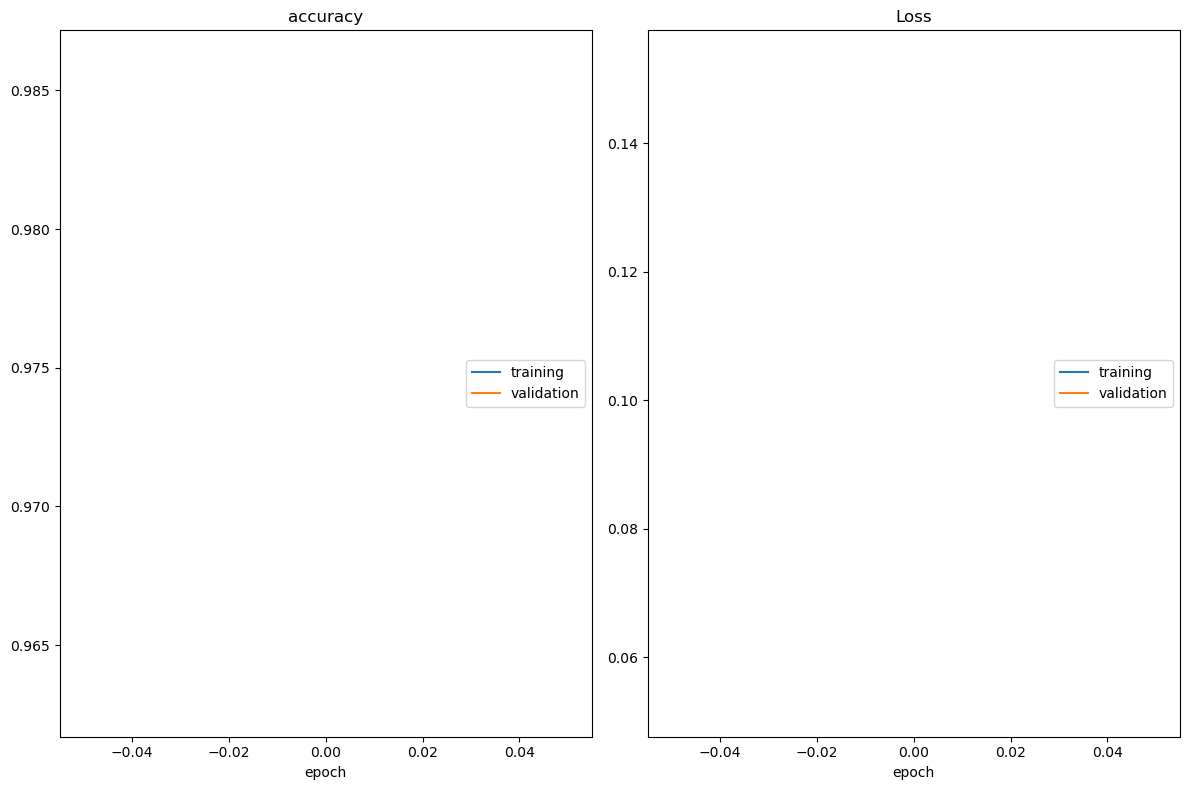

accuracy
	training         	 (min:    0.963, max:    0.963, cur:    0.963)
	validation       	 (min:    0.986, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.153, max:    0.153, cur:    0.153)
	validation       	 (min:    0.053, max:    0.053, cur:    0.053)
480/480 ━━━━━━━━━━━━━━━━━━━━ 162s 318ms/step - accuracy: 0.9244 - loss: 0.3267 - val_accuracy: 0.9860 - val_loss: 0.0526


In [34]:
import numpy as np
history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 1,
    verbose = 1,
    callbacks=callbacks
)

In [35]:
model.evaluate(x_test,np.array(y_test))

300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9855 - loss: 0.0546


[0.05358484014868736, 0.9858110547065735]